In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from datetime import datetime as dt
from datetime import timedelta as td

In [3]:
df_rfm = pd.read_csv('../data/processed/DataRFM.csv')
df_trans = pd.read_csv('../data/processed/preProcessed.csv')

In [4]:
df_trans['date'] = pd.to_datetime(df_trans['date'])

months = df_trans['date'].apply(lambda x: x.month)
df_trans['month'] = months

df_trans.head()

,id_transaction,date,id_client,country,products,monetary,month
0,548370,2021-03-30 16:14:00,15528,United Kingdom,123,229.33,3
1,575767,2021-11-11 11:11:00,17348,United Kingdom,163,209.73,11
2,549106,2021-04-06 12:08:00,17045,United Kingdom,1,39.95,4
3,573112,2021-10-27 15:33:00,16416,United Kingdom,357,344.83,10
4,576630,2021-11-16 08:38:00,13816,Germany,91,199.98,11


In [5]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22104 entries, 0 to 22103
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id_transaction  22104 non-null  object        
 1   date            22104 non-null  datetime64[ns]
 2   id_client       22104 non-null  object        
 3   country         22104 non-null  object        
 4   products        22104 non-null  int64         
 5   monetary        22104 non-null  float64       
 6   month           22104 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 1.2+ MB


In [6]:
eda_trans = df_trans.copy()

eda_trans.head()

,id_transaction,date,id_client,country,products,monetary,month
0,548370,2021-03-30 16:14:00,15528,United Kingdom,123,229.33,3
1,575767,2021-11-11 11:11:00,17348,United Kingdom,163,209.73,11
2,549106,2021-04-06 12:08:00,17045,United Kingdom,1,39.95,4
3,573112,2021-10-27 15:33:00,16416,United Kingdom,357,344.83,10
4,576630,2021-11-16 08:38:00,13816,Germany,91,199.98,11


In [7]:
eda_customer = df_rfm[['id_client', 'frequency', 'recency', 'monetary', 'segment']]

eda_customer = eda_customer.merge(eda_trans[['id_client', 'country']],
                                  how='left', 
                                  on='id_client'
                                  ).drop_duplicates(keep='first', subset='id_client').reset_index(drop=True)

eda_customer.head()

,id_client,frequency,recency,monetary,segment,country
0,Unknown,3538,21,1755276.64,Top,United Kingdom
1,14646,74,22,280206.02,Top,Netherlands
2,18102,60,21,259657.30,Top,United Kingdom
3,17450,46,29,194550.79,Top,United Kingdom
4,16446,2,21,168472.50,High value,United Kingdom


In [8]:
eda_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id_client  4340 non-null   object 
 1   frequency  4340 non-null   int64  
 2   recency    4340 non-null   int64  
 3   monetary   4340 non-null   float64
 4   segment    4340 non-null   object 
 5   country    4340 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 203.6+ KB


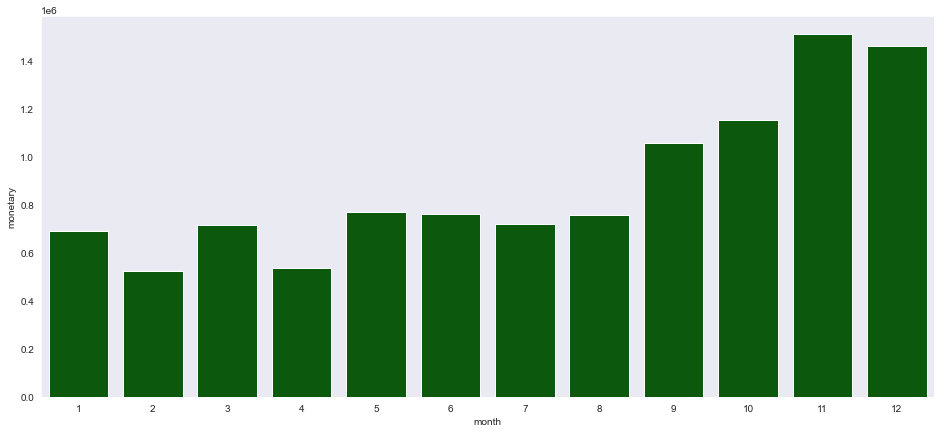

In [9]:
sns.set_style("dark")

df_plot = eda_trans.groupby('month')[['products', 'monetary']].sum()

plt.figure(figsize=(16,7))
ax = sns.barplot(data=df_plot, x=df_plot.index, y='monetary', color='darkgreen')

'''plt.xlabel('Month', {'fontsize': 11})
plt.ylabel('Monetary spent', {'fontsize': 11})
plt.title('Total spent per month in 2021', {'fontsize': 15})
plt.xticks(np.arange(0, 12), labels=['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
plt.tick_params(axis='y',
                left=False,
                labelleft=False)

plt.ticklabel_format(style='plain', axis='y')
plt.grid(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
'''

plt.show()

In [10]:
db = eda_customer.groupby(['country', 'segment'])['segment'].count().unstack(level=1)
db = db.fillna(0)
db['total'] = db[['High value', 'Lost Customers', 'Low Value', 'Medium Value', 'Top']].sum(axis=1)
db = db[(db['total'] > 5) & ((db['Top'] > 0)|(db['High value'] > 0))] 


data = []

for col in db:
  if col != 'total':
    data.append(db[col] / db['total'] * 100)


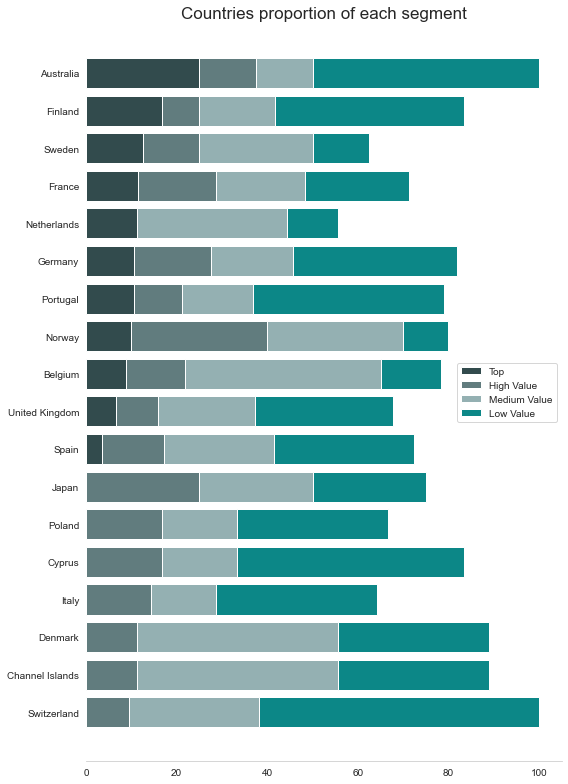

In [11]:
data_plot = pd.DataFrame(data, index=['High Value', 'Lost Customers',	'Low Value', 'Medium Value', 'Top'], columns=data[0].index).T
data_plot = data_plot.sort_values(['Top', 'High Value'])

labels = data_plot.index
top = data_plot['Top']
high = data_plot['High Value']
medium = data_plot['Medium Value']
low = data_plot['Low Value']
lost = data_plot['Lost Customers']
width=0.5


sns.set_style('whitegrid')
plt.figure(figsize=(8, 11))
plt.barh(labels, top[labels], color='#324b4d', label='Top')
plt.barh(labels, high[labels], color='#617c7e', left=top[labels], label='High Value')
plt.barh(labels, medium[labels], color='#94b0b2', left=top[labels]+high[labels], label='Medium Value')
plt.barh(labels, low[labels], color='#0c8787', left=top[labels]+high[labels]+medium[labels], label='Low Value')
plt.title('Countries proportion of each segment', {'fontsize': 17})
plt.legend()
plt.grid(False)
sns.despine(left=True)
plt.tight_layout()

Note that this is a chart of proportion, so every country needs fill up to 100%. The open space at the end of the bars represents lost customers (not shown to enhance clarity)

In [12]:
print(f"{(eda_customer.groupby('country')['monetary'].sum()['United Kingdom'] / eda_customer.groupby('country')['monetary'].sum().sum() * 100).round(2)}% of all revenue come from UK, so let´s take it out for the next chart")

84.97% of all revenue come from UK, so let´s take it out for the next chart


In [13]:
data_plot = eda_customer.groupby(['country', 'segment'])['monetary'].sum().unstack(level=1).fillna(0)

data_plot = data_plot[(data_plot['Top'] > 0) | (data_plot['High value'] > 0) | (data_plot['Medium Value'] > 0)] 
data_plot.drop('United Kingdom', inplace=True)
data_plot = data_plot.sort_values(['Top', 'High value'], ascending=False).reset_index()
data_plot.head(3)

segment,country,High value,Lost Customers,Low Value,Medium Value,Top
0,Netherlands,0.00,1036.95,463.66,3739.71,280206.02
1,EIRE,0.00,0.00,0.00,4341.21,261204.69
2,Australia,2780.66,0.00,3342.65,1582.60,131401.98


In [14]:
data_plot['Total'] = (data_plot['High value'] + data_plot['Low Value'] + data_plot['Medium Value'] + data_plot['Lost Customers'] + data_plot['Top'])
data_plot = data_plot.sort_values('Total', ascending = False)
data_plot[['country', 'Total']]


segment,country,Total
0,Netherlands,285446.34
1,EIRE,265545.90
4,Germany,228867.14
3,France,209024.05
2,Australia,139107.89
7,Spain,62839.71
14,Switzerland,57222.85
10,Belgium,40278.78
5,Sweden,38378.33
12,Japan,37416.37


In [15]:
data_plot.shape

(27, 7)

<Figure size 432x288 with 0 Axes>

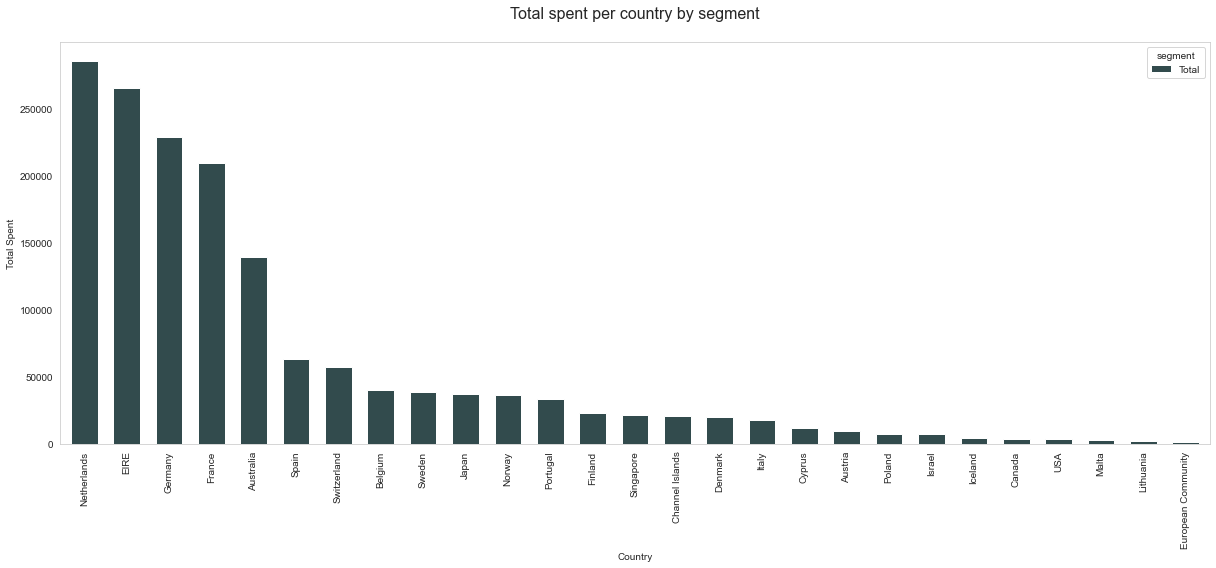

In [19]:
plt.figure()
data_plot.plot(x='country', y=['Total'], kind='bar', figsize=(17, 8), color=['#324b4d'], width=0.63)
plt.title('Total spent per country by segment\n', {'fontsize': 16})
plt.xlabel('Country')
plt.ylabel('Total Spent')
plt.grid(False)
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

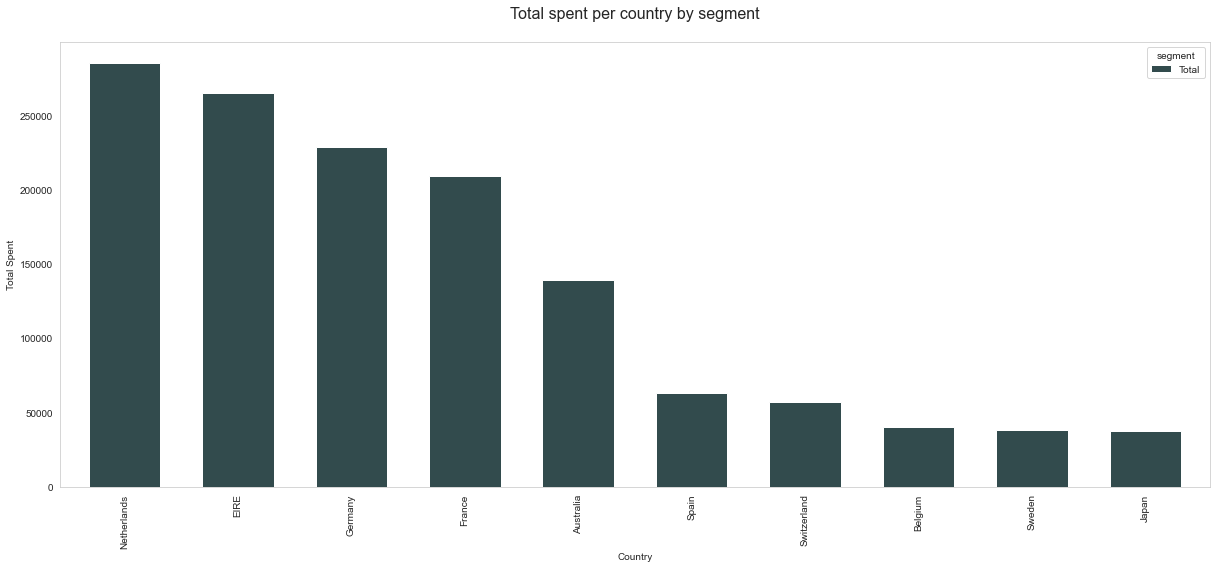

In [21]:
plt.figure()
data_plot[:10].plot(x='country', y=['Total'], kind='bar', figsize=(17, 8), color=['#324b4d'], width=0.63)
plt.title('Total spent per country by segment\n', {'fontsize': 16})
plt.xlabel('Country')
plt.ylabel('Total Spent')
plt.grid(False)
plt.tight_layout()
plt.show()